In [1]:
# Load Data
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers torch
!pip install sentencepiece
from transformers import BigBirdForSequenceClassification, BigBirdTokenizer
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
import numpy as np
import torch

## 1. Define DataSet and Dataloaders for Claims Text

In [3]:
class TextDataset(Dataset):
    def __init__(self, csv_file,label_map, tokenizer, max_length=4096): # adjust max length depending on tokenizer
        self.data_frame = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = label_map
        # redefine self.data_frame for integer valued labels
        self.data_frame['status'] = self.data_frame['status'].map(self.label_map)

    def __len__(self):
        return self.data_frame.shape[0]

    def __getitem__(self, idx):
        text = self.data_frame.iloc[idx]['claims']
        label = self.data_frame.iloc[idx]['status']

        # Encoding the text using the given tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [4]:
import torch

# Enabling gradient accumulation
accumulation_steps = 4  # How many steps to wait before performing a backward/update pass

# Optimizing memory management
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Set the max_split_size_mb to a value that works for your setup
torch.cuda.set_per_process_memory_fraction(0.9, device=0)


In [5]:
input_path = '/content/drive/MyDrive/CSCI567/project/data/text_df_all.csv'

# Load the dataset
label_map = {'ABN': 0, 'ISS': 1}
model_name = "google/bigbird-roberta-base"
tokenizer = BigBirdTokenizer.from_pretrained(model_name)
dataset = TextDataset(input_path,label_map=label_map, tokenizer= tokenizer,max_length = 4096)

# Example dataset size
total_size = len(dataset)

# Define the proportions
train_size = int(0.80* total_size)
val_size = int(0.10* total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# define dataloaders
BATCH_SIZE = 3
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

90624
11328
11329


## 2. Fine Tune Pretrained BigBird

In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup,BigBirdModel
from torch.optim import AdamW


# Number of epochs
num_epochs = 1

# load model previously saved and tuned
model_path = '/content/drive/MyDrive/CSCI567/project/bigbird_state_dict_all.pth'

# Instantiate the model
model = BigBirdForSequenceClassification.from_pretrained("google/bigbird-roberta-base")

# Load the state dict
state_dict = torch.load(model_path)

# Apply the state dict to the model
model.load_state_dict(state_dict)

# Now continue with your optimizer, scheduler, and training loop
optimizer = AdamW(model.parameters(), lr=1e-5)

# Scheduler
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(50358, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [7]:
# set model to training mode and Fine Tune
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Reset gradients at the start of the epoch
    for batch_idx, batch in enumerate(train_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss / accumulation_steps  # Normalize the loss

        # Backward pass
        loss.backward()  # Accumulate gradients

        # Optimizer and scheduler steps are performed after the specified number of accumulation steps
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_dataloader):
            optimizer.step()    # Update model parameters
            scheduler.step()    # Update learning rate
            optimizer.zero_grad()  # Reset gradients

        # Print loss or any other metrics you want to track
        # Optionally, you can print the average loss over accumulation steps
        if (batch_idx + 1) % accumulation_steps == 0:
            print(f"Loss: {loss.item() * accumulation_steps}")  # Multiply back to get the actual loss value
    print(f"epoch {epoch}")

Streaming output truncated to the last 5000 lines.
Loss: 0.08964857459068298
Loss: 0.3908727169036865
Loss: 0.8794285655021667
Loss: 0.12812839448451996
Loss: 0.08199277520179749
Loss: 0.3340492248535156
Loss: 0.03962826728820801
Loss: 0.06027154624462128
Loss: 0.1430816501379013
Loss: 0.6554423570632935
Loss: 0.06429984420537949
Loss: 0.5634241700172424
Loss: 0.2904563248157501
Loss: 0.08641466498374939
Loss: 0.058377813547849655
Loss: 0.03915136307477951
Loss: 0.6074002981185913
Loss: 0.1858784407377243
Loss: 1.31383216381073
Loss: 0.7080754637718201
Loss: 0.2770911455154419
Loss: 0.3345905840396881
Loss: 1.1902953386306763
Loss: 0.0706239566206932
Loss: 0.36057671904563904
Loss: 0.04416254162788391
Loss: 0.12579764425754547
Loss: 1.2754292488098145
Loss: 0.08505985140800476
Loss: 0.1038283109664917
Loss: 0.3645975887775421
Loss: 0.024507969617843628
Loss: 0.06054863706231117
Loss: 0.2903730571269989
Loss: 0.1941332072019577
Loss: 0.2871828079223633
Loss: 0.24692364037036896
Loss: 0.

## 3. Evaluate BigBird Performance on validation set

In [8]:
# set model to evaluation mode
model.eval()

# store predictions in list
val_predictions = []
val_labels = []

# Evaluate on validation set
with torch.no_grad():
    for batch in val_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=1)
        labels = batch['labels']

        # Store predictions
        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [9]:
# Use SKLearn library to predict F1, Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

f1 = f1_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
accuracy = accuracy_score(val_labels, val_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8302436440677966
F1 Score: 0.8778504732261957
Precision: 0.8466062239647145
Recall: 0.9114892494393879


8162
3166


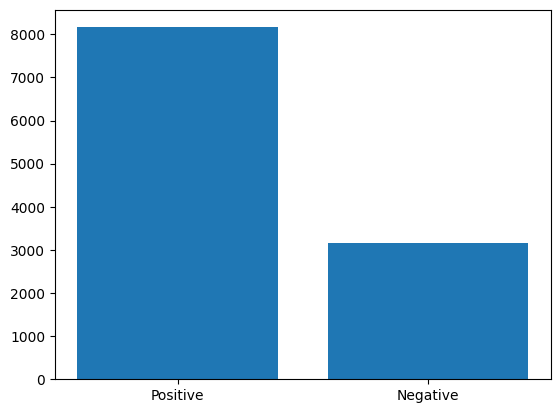

In [10]:
# Plot the proportion of positive vs. negative predictions
import matplotlib.pyplot as plt

print(val_predictions.count(1))
print(val_predictions.count(0))

plt.bar(['Positive', 'Negative'], [val_predictions.count(1), val_predictions.count(0)])
plt.show()

In [11]:
model_save_path = '/content/drive/MyDrive/CSCI567/project/bigbird_state_dict_all.pth'
torch.save(model.state_dict(), model_save_path)

In [12]:
# set model to evaluation mode
model.eval()

# store predictions in list
test_predictions = []
test_labels = []

# Evaluate on validation set
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=1)
        labels = batch['labels']

        # Store predictions
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

In [13]:
# Use SKLearn library to predict F1, Precision, Recall
#from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

f1 = f1_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.837055344690617
F1 Score: 0.882510183299389
Precision: 0.8527675276752767
Recall: 0.9144025323133738


8130
3199


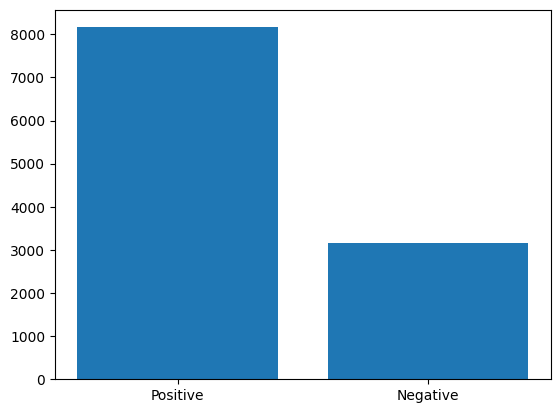

In [14]:
# Plot the proportion of positive vs. negative predictions
import matplotlib.pyplot as plt

print(test_predictions.count(1))
print(test_predictions.count(0))

plt.bar(['Positive', 'Negative'], [val_predictions.count(1), val_predictions.count(0)])
plt.show()